# Nak model analysis

Here we will show you the neurodynamics analysis of a two-dimensional system model with the example of the $I_{\rm{Na,p+}}-I_K$ Model. 

The dynamical system is given by:
$$ C\dot{V} = I_{ext} - g_L * (V-E_L)-g_{Na}*m_\infty(V)(V-E_{Na})-g_K*n*(V-E_K)$$

$$ \dot{n} = \frac{n_\infty(V)-n}{\tau(V)} $$

where

$$ m_\infty(V) = 1 \ / \ ({1+\exp(\frac{V_{\rm{n_{half}}}-V}{k_m})}) $$

$$ n_\infty(V) = 1 \ / \ ({1+\exp(\frac{V_{\rm{n_{half}}}-V}{k_n})}) $$

This model specifies a leak current $I_L$, persistent sodium current $I_{\rm{Na, p}}$ 
with instantaneous activation kinetic, and a relatively slower persistent 
potassium current $I_K$ with either high or low threshold (the two choices 
result in fundamentally different dynamics). 

In [1]:
from collections import OrderedDict

import brainpy as bp
import numpy as np

bp.profile.set(dt=0.01)

In [2]:
def get_NaK_model(V_th=20., type='low-threshold'):
    """The I-Na,p+I-K model.

    Parameters
    ----------
    V_th : float
        A float number that specifies the threshold of treating
        elevated membrane potential as a spike. Unit in ``mV``.
        Default is 20.
    type : str
        A string that specifies whether the I-Na,p+I-K model has a high
        (``high-threshold``) or low threshold (``low-threshold``).
        Default is ``low-threshold``.

    Returns
    -------
    return_dict : bp.NeuType
        The necessary variables.
    """

    if not (type == 'low-threshold' or 'high-threshold'):
        raise ValueError("Argument `type` must be either `low-threshold`"
                         "or `high-threshold`")

    if type == 'high-threshold':
        C = 1
        E_L = -80
        g_L = 8
        g_Na = 20
        g_K = 10
        E_K = -90
        E_Na = 60
        Vm_half = -20
        k_m = 15
        Vn_half = -25
        k_n = 5
        tau = 1
    else:  # low-threshold
        C = 1
        E_L = -78  # different from high-threshold model
        g_L = 8
        g_Na = 20
        g_K = 10
        E_K = -90
        E_Na = 60
        Vm_half = -20
        k_m = 15
        Vn_half = -45  # different from high-threshold model
        k_n = 5
        tau = 1

    ST = bp.types.NeuState({'V': -65., 'n': 0., 'spike': 0., 'input': 0.})

    @bp.integrate
    def int_n(n, t, V):
        n_inf = 1 / (1 + np.exp((Vn_half - V) / k_n))
        dndt = (n_inf - n) / tau
        return dndt

    @bp.integrate
    def int_V(V, t, n, I_ext):
        m_inf = 1 / (1 + np.exp((Vm_half - V) / k_m))
        I_leak = g_L * (V - E_L)
        I_Na = g_Na * m_inf * (V - E_Na)
        I_K = g_K * n * (V - E_K)
        dvdt = (-I_leak - I_Na - I_K + I_ext) / C
        return dvdt

    def update(ST, _t):
        n = np.clip(int_n(ST['n'], _t, ST['V']), 0., 1.)
        V = int_V(ST['V'], _t, n, ST['input'])
        spike = np.logical_and(ST['V'] < V_th, V >= V_th)
        ST['V'] = V
        ST['n'] = n
        ST['spike'] = spike
        ST['input'] = 0.

    return bp.NeuType(name="NaK_model",
                      ST=ST,
                      steps=update,
                      mode='vector')

### Phase plane analysis

SymPy solve "int_n(V, n) = 0" to "n = f(V, )", success.
SymPy solve "int_V(V, n) = 0" to "n = f(V, )", success.


<string>:2: RuntimeWarning: divide by zero encountered in true_divide


SymPy solve derivative of "int_V(V, n)" by "V", success.
SymPy solve derivative of "int_V(V, n)" by "n", success.
SymPy solve derivative of "int_n(V, n)" by "V", success.
SymPy solve derivative of "int_n(V, n)" by "n", success.
Fixed point #1 at V=-51.60868767199546, n=0.2105293582848025 is a unstable-focus.


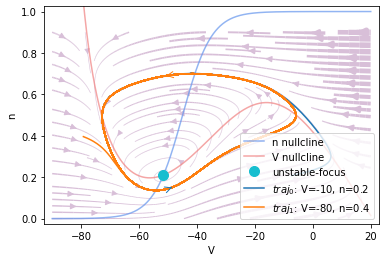

In [3]:
NaK_neuron = get_NaK_model()

analyzer = bp.analysis.PhasePlane(
    model=NaK_neuron,
    target_vars=OrderedDict(V=[-90, 20], n=[0., 1.]),
    fixed_vars={'I_ext': 50., 'input': 50.})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -10, 'n': 0.2}, {'V': -80, 'n': 0.4}],
                         duration=100.,
                         show=True)

### Codimension 1 bifurcation analysis

Here we show the codimension 1 bifurcation analysis of the $I_{\rm{Na,p+}}-I_K$ Model, in which $I_{ext}$ is varied in [0., 50.].

SymPy solve "int_n(V, n, I_ext) = 0" to "n = f(V, I_ext)", success.
SymPy solve derivative of "int_V(V, n, I_ext)" by "V", success.
SymPy solve derivative of "int_V(V, n, I_ext)" by "n", success.
SymPy solve derivative of "int_n(V, n, I_ext)" by "V", success.
SymPy solve derivative of "int_n(V, n, I_ext)" by "n", success.


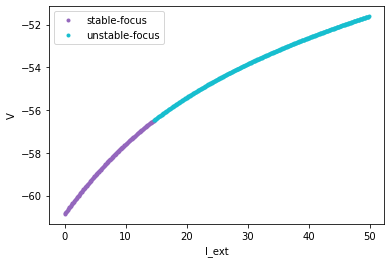

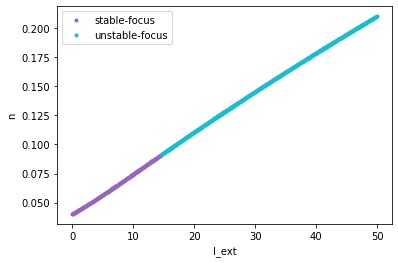

In [4]:
analyzer = bp.analysis.Bifurcation(
    model=get_NaK_model(),
    target_pars={'I_ext': [0, 50.]},
    target_vars={"V": [-90., 20.], 'n': [0., 1.]},
    numerical_resolution=0.1)
analyzer.plot_bifurcation(show=True)

### Codimension 2 bifurcation analysis

Codimension 2 bifurcation analysis of the $I_{\rm{Na,p+}}-I_K$ Model, in which $I_{ext}$ is varied in [0., 50.], and "Vn_half" is varied in [-50, -40].

SymPy solve "int_n(V, n, I_ext, Vn_half) = 0" to "n = f(V, I_ext,Vn_half)", success.
SymPy solve derivative of "int_V(V, n, I_ext, Vn_half)" by "V", success.
SymPy solve derivative of "int_V(V, n, I_ext, Vn_half)" by "n", success.
SymPy solve derivative of "int_n(V, n, I_ext, Vn_half)" by "V", success.
SymPy solve derivative of "int_n(V, n, I_ext, Vn_half)" by "n", success.


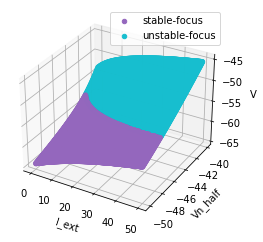

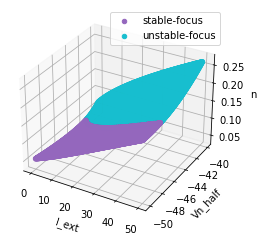

In [5]:
analyzer = bp.analysis.Bifurcation(
    model=get_NaK_model(),
    target_pars={'I_ext': [0, 50.], 'Vn_half': [-50, -40]},
    target_vars={"V": [-90., 20.], 'n': [0., 1.]},
    numerical_resolution=0.1)

analyzer.plot_bifurcation(show=True)

### Reference

[1] Izhikevich, Eugene M. Dynamical systems in neuroscience (Chapter 
4). MIT press, 2007.